In [1]:
import os
import sys

import numpy as np
from astropy import units as u

import sbfit
import sbfit.model


Bad key "text.kerning_factor" on line 4 in
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Load data

Initialize an `ObservationList` object.

In [2]:
observations = sbfit.ObservationList()

Load images into the `ObservationList` object.

In [3]:
image_dir = "a3667/chandra"

obsids = [513, 889, 5751, 5752, 5753, 6292, 6295, 6296]

for obsid in obsids:
    observations.add_observation_from_file(f"a3667/chandra/{obsid}_band1_thresh.img", 
                                           f"a3667/chandra/{obsid}_band1_thresh.expmap", 
                                           f"a3667/chandra/{obsid}_band1_nxb_full.img", 
                                           bkg_norm_type="count",
                                           bkg_norm_keyword="bkgnorm", )

# Read region file

In [4]:
epanda = sbfit.read_region("a3667.reg")

# Extract a profile
The region set loaded in the previous step is used.

In [5]:
a3667_chandra_profile = observations.get_profile(epanda, channel_width=0.2)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51444.513808 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 51797.187928 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53529.557755 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53534.009225 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53539.451968 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53532.193692 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53536.858264 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53541.426528 from DATE-END'. [astropy.wcs.wcs]


First, let's bin the profile.

/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:506: UserWarning: No model set.


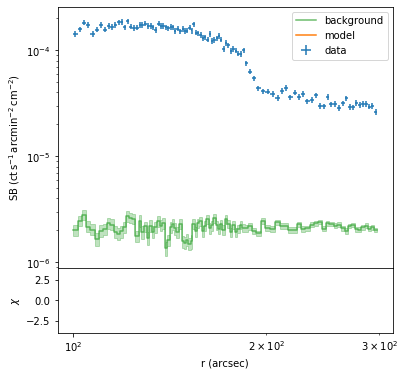

In [6]:
a3667_chandra_profile.rebin(100, 300,method="min_cts",min_cts=300,log_width=0.005,lin_width=1)
a3667_chandra_profile.plot(scale="loglog")

- For *Chandra* observations, the PSF is small enough to use an identity smoothing matrix, which is the default setting.
- For *XMM-Newton*, a King profile smoothing matrix is essential to account for the broad PSF. The parameters of the profile are provided in the PSF calibration files.

In [7]:
a3667_chandra_profile.set_smooth_matrix("identity", king_alpha=1.4,king_rc=10,sigma=1)

# Set models
Set a double power law model and load it into the profile.

The `+` operator can add multiple model instances into a compound model instance.

Here we use the combination of a `DoublePowerLaw` model and a `Constant` model, which represents the ICM emission and the X-ray sky background.

In [8]:
dpl = sbfit.model.DoublePowerLaw()
cst = sbfit.model.Constant()

a3667_chandra_profile.set_model(dpl + cst)

In [9]:
print(a3667_chandra_profile.model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <DoublePowerLaw(norm=1., a1=0.1, a2=1., r=1., c=2.)>

    [1]: <Constant(norm=0.)>
Parameters:
    norm_0 a1_0 a2_0 r_0 c_0 norm_1
    ------ ---- ---- --- --- ------
       1.0  0.1  1.0 1.0 2.0    0.0


Before fit, set initial parameters that make the model profile close to the observed profile.

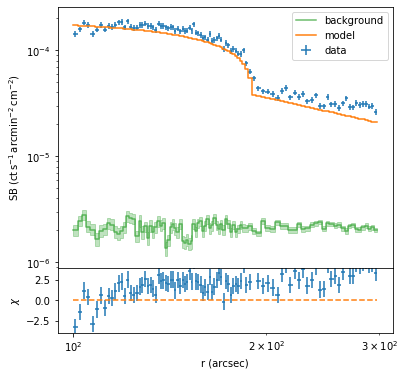

In [10]:
a3667_chandra_profile.model.norm_0 = 4e-4
a3667_chandra_profile.model.a1_0 = 0
a3667_chandra_profile.model.a2_0 = 0.6
a3667_chandra_profile.model.r_0 = 190
a3667_chandra_profile.model.c_0 = 2.4
a3667_chandra_profile.model.norm_1 = 5e-7


a3667_chandra_profile.calculate()
a3667_chandra_profile.plot()


Set parameter constraints for the model in case that the optimizer goes too far.

In [11]:
a3667_chandra_profile.model.norm_1.fixed = True

a3667_chandra_profile.model.norm_0.bounds = (1e-4, 6e-4)
a3667_chandra_profile.model.a1_0.bounds = (-0.7, 0.3)
a3667_chandra_profile.model.a2_0.bounds = (0.4, 1.1)
a3667_chandra_profile.model.r_0.bounds = (150, 220)
a3667_chandra_profile.model.c_0.bounds = (1.8, 3.3)

# Fit

In [12]:
a3667_chandra_profile.fit(show_step=True, tolerance=0.01)

Start fit
C-stat: 758.163
[4.0e-04 0.0e+00 6.0e-01 1.9e+02 2.4e+00]
C-stat: 196.707
[ 4.06045241e-04 -2.62415764e-07  5.45183030e-01  1.90317950e+02
  2.42646996e+00]
C-stat: 187.034
[ 4.06798505e-04 -5.11746135e-06  5.39601292e-01  1.90424932e+02
  2.43201744e+00]
C-stat: 183.777
[4.04343539e-04 3.66157430e-05 5.36878419e-01 1.90761265e+02
 2.44154721e+00]
C-stat: 164.992
[ 3.95723620e-04 -4.82609007e-02  5.25598841e-01  1.90899419e+02
  2.54090832e+00]
C-stat: 151.797
[ 3.78202957e-04 -1.28461870e-01  5.01287348e-01  1.90931370e+02
  2.73903588e+00]
C-stat: 150.861
[ 3.70078365e-04 -1.34937207e-01  4.90324252e-01  1.90965436e+02
  2.81375093e+00]
C-stat: 150.850
[ 3.65523622e-04 -1.36668131e-01  4.84207631e-01  1.90980242e+02
  2.85227244e+00]
C-stat: 150.848
[ 3.65522341e-04 -1.36607911e-01  4.84229641e-01  1.90979423e+02
  2.85266156e+00]
Iteration terminated.
Degree of freedom: 91; C-stat: 150.8482
norm_0:	3.66e-04
a1_0:	-1.37e-01
a2_0:	4.84e-01
r_0:	1.91e+02
c_0:	2.85e+00
Uncerta

150.8482436926812

The uncertainties here are obtained from the Hessian matrix in the fit routine. To better estimate the uncertainties, 
we need to perform a Monte-Carlo Markov Chain analysis.

Let's have a look of the best-fit profile first.

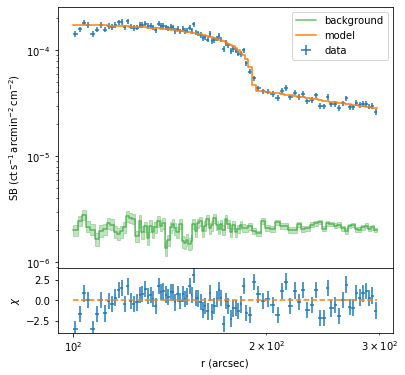

In [13]:
a3667_chandra_profile.calculate()
a3667_chandra_profile.plot(scale="loglog")

Now we use Monte-Carlo Markov Chain method to estimate the uncertainties. It takes hours to finish.

In [14]:
a3667_chandra_profile.mcmc_error(nsteps=5000, burnin=500)

100%|██████████| 5000/5000 [12:41:20<00:00,  9.14s/it]  


Degree of freedom: 91; C-stat: 151.9220
norm_0:	0.00036770547592092205	+2.751e-05	-6.728e-06
a1_0:	-0.14406958071285275	+1.881e-02	-4.804e-02
a2_0:	0.48620294404844655	+3.518e-02	-9.066e-03
r_0:	190.6503156926112	+2.102e-01	-1.409e+00
c_0:	2.8516292265238197	+7.587e-02	-1.737e-01


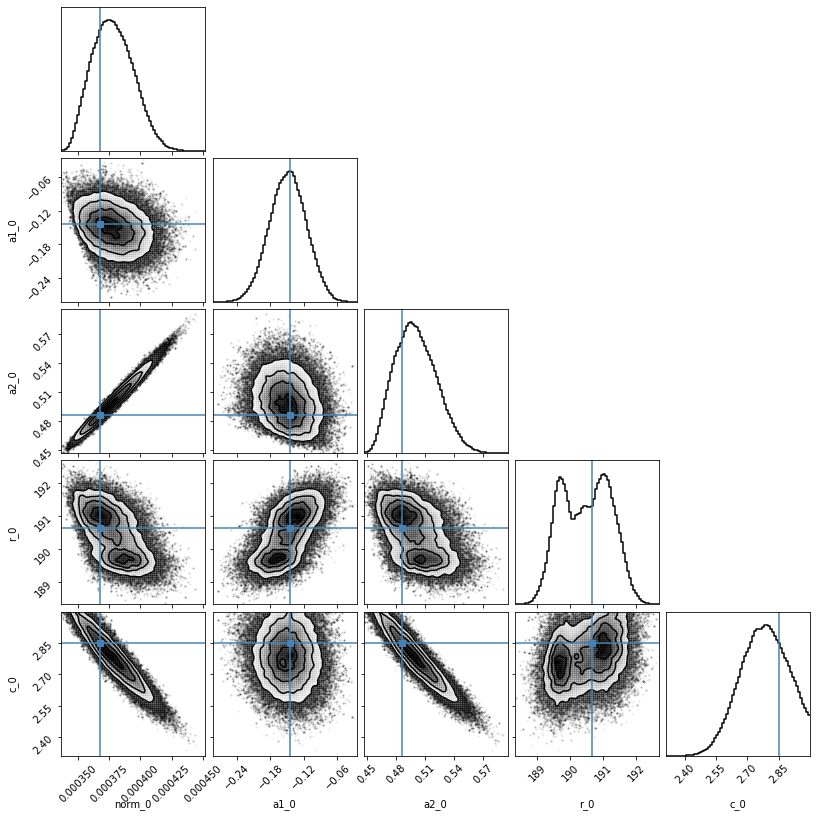

In [16]:
a3667_chandra_profile.plot(plot_type="contour")